# Santander Value Prediction Challenge

## Description

According to Epsilon research, 80% of customers are more likely to do business with you if you provide personalized service. Banking is no exception.

The digitalization of everyday lives means that customers expect services to be delivered in a personalized and timely manner… and often before they´ve even realized they need the service. In their 3rd Kaggle competition, Santander Group aims to go a step beyond recognizing that there is a need to provide a customer a financial service and intends to determine the amount or value of the customer's transaction. This means anticipating customer needs in a more concrete, but also simple and personal way. With so many choices for financial services, this need is greater now than ever before.

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

## Evaluation

![Evaluation Metric](./images/evaluation.png)

## Importing Python Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing

from collections import defaultdict

# Additional Configuration
pd.set_option('display.max_columns', 0)
sns.set(style="whitegrid", color_codes=True)
matplotlib.rc('axes', edgecolor='white')
matplotlib.rc('xtick', color='white')
matplotlib.rc('ytick', color='white')
%matplotlib inline

## Explorarory Data Analysis

### 1. Loading the Datasets

In [2]:
%%time
train_raw = pd.read_csv('./datasets/train.csv')
test_raw = pd.read_csv('./datasets/test.csv')

print("Training dataset shape: ", train_raw.shape)
print("Testing dataset shape: ", test_raw.shape)

Training dataset shape:  (4459, 4993)
Testing dataset shape:  (49342, 4992)
CPU times: user 1min, sys: 4.55 s, total: 1min 5s
Wall time: 1min 5s


In [3]:
train_raw.head()

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,b4ced4b7a,0b8e10df6,603e85eb7,605728195,4e8196700,f115e74c0,9ca0eee11,472cd130b,ee7e4581d,3e0e55648,a939664aa,b0f5ed414,a72e0bf30,e662f1672,54b1c1bc0,ec1425047,78a879b5d,...,7fd35c77a,9d9e518a3,99258443a,1d81e197a,831a9e087,de471ea65,8781e4b91,dc5ba677f,df3ac443c,79203fbab,f1ab19e7a,300398f1c,6eefca12e,22bf44001,19915a6d3,20a325694,8afae1db8,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,1300000.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,...,0,0,0,0.0,0,0,1266666.66,0,0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,24000000.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,...,0,0,0,0.0,0,0,0.00,0,0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,...,0,0,0,0.0,0,0,0.00,0,0,0,0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0.0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0,0.0,0.0,0,...,0,0,0,0.0,0,0,0.00,0,0,0,0,0.0,0,0,

In [4]:
test_raw.head()

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,11ad148bd,ea18d720e,408d86ce9,69d8b4020,b0868a049,80b14398e,ecdef52b2,c36bcacc5,151d318cd,ab0cddb90,2d6bd8275,dfdf4b580,c87722678,a8c320153,7df8788e8,a04684f1f,fa977f17b,feed9d437,645b47cde,7298ca1ef,d80abf8bc,654dd8a3b,7fc39583c,8c94b6675,e421c414e,5b91580ee,964335fdf,5a86cabd0,6cb207ac9,c1bc828da,e90ed19da,c4d38135f,968b01ca3,26b423c42,0656586a4,b4ced4b7a,0b8e10df6,603e85eb7,605728195,4e8196700,f115e74c0,9ca0eee11,472cd130b,ee7e4581d,3e0e55648,a939664aa,b0f5ed414,a72e0bf30,e662f1672,54b1c1bc0,ec1425047,78a879b5d,bd550871c,...,7fd35c77a,9d9e518a3,99258443a,1d81e197a,831a9e087,de471ea65,8781e4b91,dc5ba677f,df3ac443c,79203fbab,f1ab19e7a,300398f1c,6eefca12e,22bf44001,19915a6d3,20a325694,8afae1db8,c283d4609,11114a47a,b961b0d59,103b8a033,43d70cc4d,09184c121,08c089775,572d36d31,1de239e78,d7568383a,8d7bfb911,5964f1856,6c7bf200b,b3058e9ba,108fe14ef,dcfcddf16,5fad07863,b904b8345,408021ef8,ef30f6be5,e29d22b59,a19b05919,e849e3ae0,05f11f48f,49f11e712,c959d372a,b625fe55a,f642213a6,6df033973,1834f29f5,31e434a58,e431708ff,fb42abc0d,88263a031,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,9dc52515a,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.528249e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.175880e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281465.985732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.680713e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### 2. Displaying Dataset Information

In [5]:
dtype_df = train_raw.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


#### Columns with Zero Values Proportion

In [6]:
zero_values_train = np.abs(-100 + (train_raw.astype(bool).sum(axis=0) * 100)/train_raw.shape[0])
zero_values_test = np.abs(-100 + (test_raw.astype(bool).sum(axis=0) * 100)/test_raw.shape[0])

In [7]:
zero_df = pd.DataFrame({'Train': zero_values_train, 'Test': zero_values_test})
zero_df = zero_df.drop(['ID'])
zero_df.sort_values(['Test'])
important_columns = zero_df[zero_df['Test'] < 93].index.tolist()
zero_df[zero_df['Test'] < 93].index

Index(['024c577b9', '02861e414', '041c5d0c9', '0572565c2', '0c9462c08',
       '0d51722ca', '0ff32eb98', '11e12dbe8', '122c135ed', '15ace8c9f',
       '1702b5bf0', '190db8488', '1931ccfdd', '1c71183bb', '1db387535',
       '1fe5d56b9', '20aa07010', '23310aa6f', '241f0f867', '26fc93eb7',
       '29c059dd2', '2e103d632', '2ec5b290f', '32174174c', '324921c7b',
       '3bdee45be', '3d6d38290', '44d5b820f', '491b9ee45', '4bcf15776',
       '51d4053c7', '57dd44c29', '58232a6fb', '58e056e12', '58e2e02e6',
       '5a1589f1a', '5c6487af1', '62e59a501', '62fb56487', '63c094ba4',
       '6619d81fc', '66ace2992', '68a945b18', '6c0e0801a', '6c5c8869c',
       '6eef030c1', '703885424', '70feb1494', '850027e38', '8781e4b91',
       '87ffda550', '8e4d0fe45', '91f701ba2', '961b91fe7', '963a49cdc',
       '9fd594eec', 'a6b6bc34a', 'a93118262', 'aac52d8d9', 'ad009c8b9',
       'adb64ff71', 'b43a7cfd5', 'b4cfe861f', 'b6daeae32', 'b7c931383',
       'bd6da0cca', 'c10f31664', 'c47340d97', 'c5a231d81', 'c8d5

#### Columns with Constant Value

In [8]:
unique_df = train_raw.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

#### Removing Columns with Constant Values (Single Unique Value)

In [9]:
train_df = train_raw.drop(constant_df.col_name.tolist(), axis=1)
test_df = test_raw.drop(constant_df.col_name.tolist(), axis=1)
train_df.shape

(4459, 4737)

### 3. Target Distribution

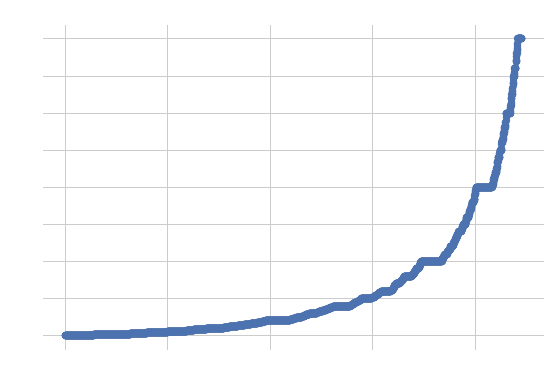

In [10]:
plt.figure(figsize=(9,6))
plt.scatter(range(train_raw.shape[0]), np.sort(train_raw['target'].values))
plt.xlabel('index', fontsize=12, color='#FFFFFF')
plt.ylabel('Target', fontsize=12, color='#FFFFFF')
plt.title("Target Distribution", fontsize=14, color='#FFFFFF')
plt.show()

#### Target Histogram

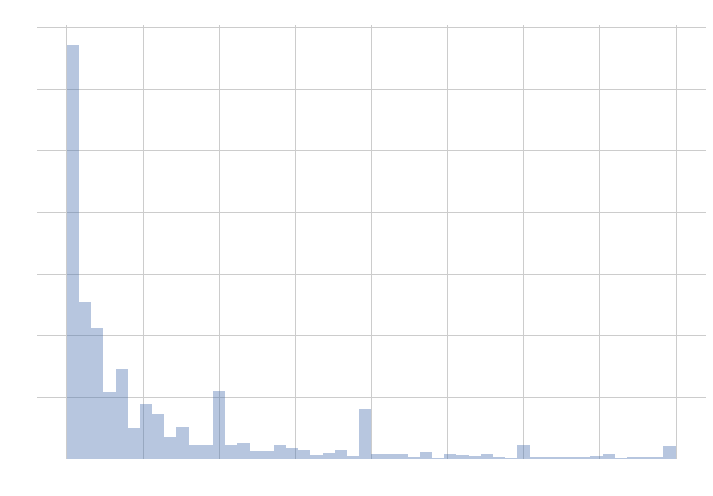

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(train_raw["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12, color='white')
plt.title("Target Histogram", fontsize=14, color='white')
plt.show()

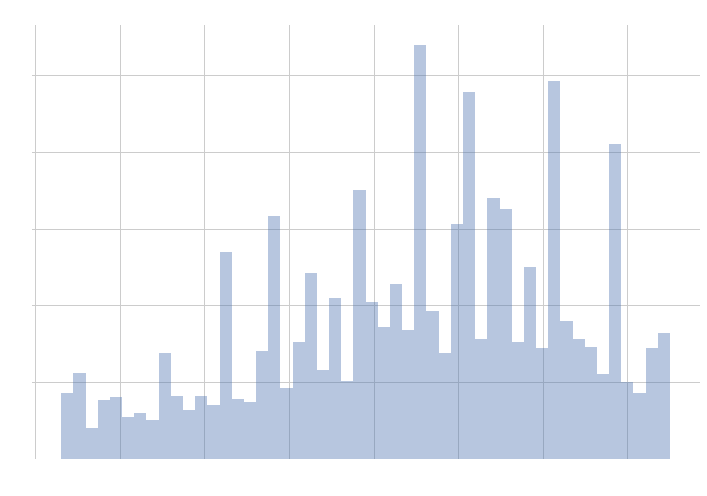

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_raw["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12, color='white')
plt.title("Target Histogram", fontsize=14, color='white')
plt.show()

### 4. Correlation Analysis

In [13]:
labels = [x for x in train_df.columns if x not in ['ID', 'target']]
values = [np.corrcoef(train_df[x].values, train_df['target'].values)[0,1] for x in train_df.columns if x not in ['ID', 'target']]

corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

# Generating Bar Plot For Correlation > 0.2
# corr_df = corr_df[(corr_df['corr_values']>0.2) | (corr_df['corr_values']<-0.2)]
# ind = np.arange(corr_df.shape[0])
# width = 0.9
# fig, ax = plt.subplots(figsize=(12,50))
# rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
# ax.set_yticks(ind)
# ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
# ax.set_xlabel("Correlation coefficient", color='white')
# ax.set_title("Correlation coefficient of the variables", color='white')

# plt.show()

#### Correlation Heat Map

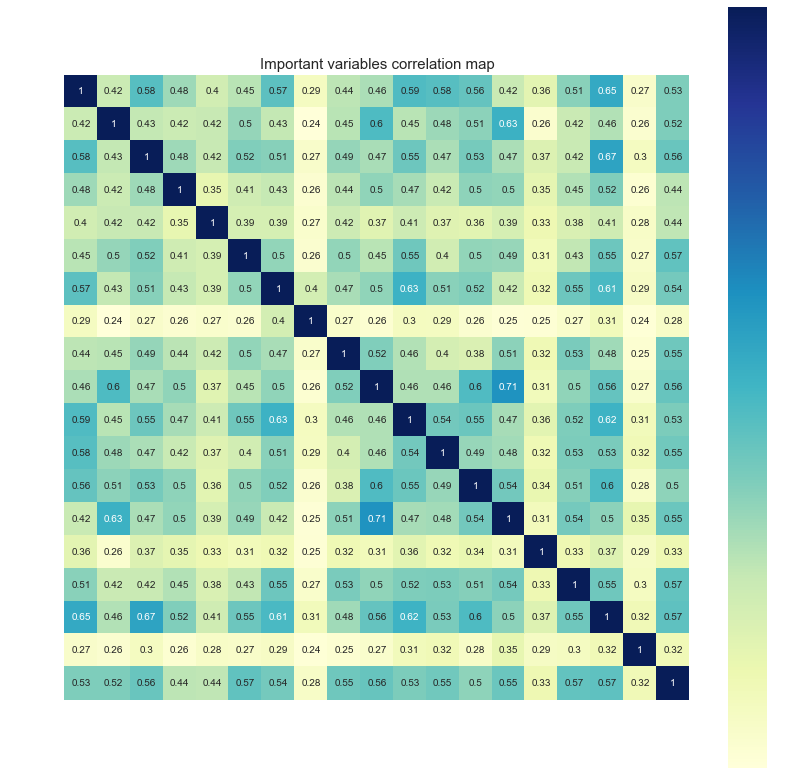

In [14]:
cols_to_use = corr_df[(corr_df['corr_values']>0.25) | (corr_df['corr_values']<-0.25)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='pearson')
f, ax = plt.subplots(figsize=(14, 14))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

### 5. Feature Engineering

In [15]:
train_pre = train_df.drop(['ID', 'target'], axis=1)
train_Y = np.log1p(train_df['target'].values)
test_pre = test_df.drop(['ID'], axis=1)

#### Selecting Important Features

In [16]:
train_imp_feat_train = train_pre[important_columns]
train_imp_feat_test = test_pre[important_columns]

train_pre = train_pre.drop(important_columns, axis=1)
test_pre = test_pre.drop(important_columns, axis=1)

#### Standarize the Data

In [ ]:
%%time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit on training set only.
scaler.fit(train_pre)

# Apply transform to both the training set and the test set.
train_scaled = scaler.transform(train_pre)
test_scaled = scaler.transform(test_pre)

scaled_df_train = pd.DataFrame(train_scaled, columns=train_pre.columns)
scaled_df_test = pd.DataFrame(test_scaled, columns=test_pre.columns)

CPU times: user 2.7 s, sys: 2.36 s, total: 5.07 s
Wall time: 5.3 s


#### Truncated SVD

In [ ]:
%%time
svd = TruncatedSVD(n_components=3500)
svd.fit(scaled_df_train)

In [ ]:
# Printing the explained variance
plt.figure(figsize=(20,10))
plt.plot(variance_sum)
plt.grid()

In [ ]:
%%time
# Make an instance of the Model
svd_selected = TruncatedSVD(n_components=1750, n_iter=10,random_state=42)
svd_selected.fit(scaled_df_train)

From the previous graph we can see that around 1750 components are necessary to explain most of the variance of the data, so this is a good number of components to try.

In [ ]:
scaled_df_train = svd_selected.transform(scaled_df_train)
scaled_df_test = svd_selected.transform(scaled_df_test)

In [ ]:
svd_features_train = pd.DataFrame(data = scaled_df_train)
svd_features_test = pd.DataFrame(data = scaled_df_test)

#### Final Dataset

In [ ]:
train_X = pd.concat([train_imp_feat_train, svd_features_train], axis = 1)
test_X = pd.concat([train_imp_feat_test, svd_features_test], axis = 1)
train_X['target'] = train_Y

### 6. Models

#### Training Helper Methods

In [ ]:
def fit_model(model, training, validation, cross_val=False, cv_folds=5):
    predictors = [x for x in training.columns if x not in ['target']]
    model.fit(training[predictors], training['target'])
    #Predict values:
    training_predictions = model.predict(training[predictors])
    validation_predictions = model.predict(validation[predictors])
    model_report(training, validation, training_predictions, validation_predictions)

    if cross_val:
        evaluate_cross_validation(model, training, cv_folds)
        
def fit_lgbm(model, training, validation, cross_val=False, cv_folds=5):
    predictors = [x for x in training.columns if x not in ['target']]
    model.fit(training[predictors], training['target'],
              eval_set=[(validation[predictors], validation['target'])], eval_metric='l2',
              early_stopping_rounds=100,
              verbose=False)
    #Predict values:
    training_predictions = model.predict(training[predictors])
    validation_predictions = model.predict(validation[predictors])
    model_report(training, validation, training_predictions, validation_predictions)
    
    if cross_val:
        evaluate_cross_validation(model, training, cv_folds)
    
def train_lgbm(params, training, validation, cross_val=False, cv_folds=5, boosting_rounds=200):
    predictors = [x for x in training.columns if x not in ['target']]
    # Create LGB Dataset for the model
    lgb_train = lgb.Dataset(training[predictors], training['target'])
    lgb_eval = lgb.Dataset(validation[predictors], validation['target'], reference=lgb_train)
    
    gbm = lgb.train(params, lgb_train, num_boost_round=boosting_rounds, valid_sets=lgb_eval, early_stopping_rounds=100, 
                        verbose_eval=False)
    #Predict values:
    training_predictions = gbm.predict(training[predictors], num_iteration=gbm.best_iteration)
    validation_predictions = gbm.predict(validation[predictors], num_iteration=gbm.best_iteration)
    
    model_report(training, validation, training_predictions, validation_predictions)
    return gbm

def model_report(training, validation, training_predictions, validation_predictions):
    #Print model report:
    print ("\nModel Report")
    print ("Training")
    print ("Mean Absolute Error : %.4g" % mean_absolute_error(training['target'].values, training_predictions))
    print ("Root Mean Squared Error : %.4g" % np.sqrt(mean_squared_error(training['target'].values, training_predictions)))
    print ("R2 Score: %4f" % r2_score(training['target'].values, training_predictions))
    print ("\n")
    print ("Validation")
    print ("Mean Absolute Error : %.4g" % mean_absolute_error(validation['target'].values, validation_predictions))
    print ("Root Mean Squared Error : %.4g" % np.sqrt(mean_squared_error(validation['target'].values, validation_predictions)))
    print ("R2 Score: %4f" % r2_score(validation['target'].values, validation_predictions))
    
def evaluate_cross_validation(model, training, K):
    predictors = [x for x in training.columns if x not in ['target']]
    cv = KFold(n_splits=K, shuffle=True, random_state=2)
    scores = cross_val_score(model, training[predictors], training['target'], scoring='neg_mean_squared_error', cv=cv)
    print ("")
    print(scores)
    print("Mean score: {0:.3f} (+/-{1:.3f})".format(scores.mean(), scores.std()))
    
def grid_search(model, param_grid, training, validation, cv):
    predictors = [x for x in training.columns if x not in ['target']]
    grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=1, cv=cv)
    grid_result = grid_search.fit(training[predictors], training['target'])

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    validation_predictions = grid_result.predict(validation[predictors])

    print ("Validation")
    print ("Mean Absolute Error : %.4g" % mean_absolute_error(validation['target'].values, validation_predictions))
    print ("Root Mean Squared Error : %.4g" % np.sqrt(mean_squared_error(validation['target'].values, validation_predictions)))
    print ("R2 Score: %4f" % r2_score(validation['target'].values, validation_predictions))

#### Splitting the Datasets

In [ ]:
training, validation = train_test_split(train_X, test_size=0.2, random_state=8)

print("Dataset Size: ", train_X.shape)
print("Training Dataset Size: ", training.shape)
print("Validation Dataset Size: ", validation.shape)

#### Extra Trees Model

In [ ]:
%%time
from sklearn import ensemble
extra_model = ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=8, max_features=0.5, n_jobs=-1, random_state=0)
fit_model(extra_model, training, validation, cross_val=True)

In [ ]:
## plot the importances ##
feat_names = train_X.columns.values
importances = extra_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in extra_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(5,5))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
# Predicting the target
pred_test_y = extra_model.predict(test_X)
pred_test_exp = np.expm1(pred_test_y)

# Creating Submission File
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_exp
sub_df.to_csv("./predictions/baseline_extra_svd_1.csv", index=False)

#### LightGBM Model

In [ ]:
%%time
lgbm = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.01, num_leaves=32, n_estimators=1000, max_depth=8, 
                         min_child_weight=1, reg_alpha=0.3, reg_lambda=0.2, min_split_gain=2, subsample=0.5, 
                         subsample_freq=5)
fit_lgbm(lgbm, training, validation, cross_val=False)

In [ ]:
%%time
# Tunning Parameters
max_depth = range(3, 10, 2)
min_child_weight = range(1, 6, 2)
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)
kfold = KFold(n_splits=5, shuffle=True, random_state=2)
grid_search(lgbm, param_grid, training, validation, kfold)